In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pprint import pprint
from embedding_processor import EmbeddingProcessor
import plotter

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

In [3]:
# Check torch version and CUDA status if GPU is enabled.
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled.

2.5.0+cu121
True


In [4]:
'''
import and load data
'''

data_dir = '/content/drive/MyDrive/data/collection_with_abstracts.csv'
embedding_processor = EmbeddingProcessor(data_dir)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
'''
df header
'''

embedding_processor.df.head(2)

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Abstract
0,39435445,Editorial: The operationalization of cognitive...,"Winter M, Probst T, Tallon M, Schobel J, Pryss R.",Front Neurosci. 2024 Oct 7;18:1501636. doi: 10...,Winter M,Front Neurosci,2024,2024/10/22,PMC11491427,NaN,10.3389/fnins.2024.1501636,NaN
1,39398866,Characterization of arteriosclerosis based on ...,"Zhou J, Li X, Demeke D, Dinh TA, Yang Y, Janow...",J Med Imaging (Bellingham). 2024 Sep;11(5):057...,Zhou J,J Med Imaging (Bellingham),2024,2024/10/14,PMC11466048,NaN,10.1117/1.JMI.11.5.057501,PURPOSE: Our purpose is to develop a computer ...


In [6]:
'''
Check for missing value
'''

embedding_processor.df.isna().sum()

,0
PMID,0
Title,0
Authors,0
Citation,0
First Author,0
Journal/Book,0
Publication Year,0
Create Date,0
PMCID,5000
NIHMS ID,10494


For my analysis, I will use 'Title' and 'Abstract' features.

In [7]:
'''
Check for missing values
'''
embedding_processor.df.Abstract.isna().sum()

213

In [8]:
'''
% of missing values from Abstract
'''
missing_Value = ( embedding_processor.df.Abstract.isna().sum() / embedding_processor.df.shape[0]) * 100
missing_Value

1.8602620087336246

There are 213 (1.86%) missing value in the `Abstract` feature.
It is safe to remove the missing rows from the ``Abstract`` feature.

In [9]:
'''
Drop NA values
'''
embedding_processor.df_cleaned = embedding_processor.df.dropna(subset=['Abstract'])
embedding_processor.df_cleaned.shape

(11237, 12)

In [10]:
pprint(f"the original data contain {embedding_processor.df.shape[0]} rows. Now we are left with {embedding_processor.df_cleaned.shape[0]}")

'the original data contain 11450 rows. Now we are left with 11237'


In [11]:
'''
Generate embeddings for the cleaned DataFrame which
will be used for similarity computation

'''

result_df = embedding_processor.process_embeddings()

/content/embedding_processor.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_cleaned["titleAbstractNew"] = (
/content/embedding_processor.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_cleaned["titleAbstractNew"] = self.df_cleaned["titleAbstractNew"].apply(
/content/embedding_processor.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [12]:
'''
Filter Relevant Papers Based on Similarity Threshold
'''

similarity_threshold = 0.4
relevant_data = result_df[result_df['titleAbstractNew_Similarity'] > similarity_threshold]
irrelevant_data = result_df[result_df['titleAbstractNew_Similarity'] <= similarity_threshold]
print(f'relevant data shape: {relevant_data.shape} --- irrrelevant data shape: {irrelevant_data.shape}')

relevant data shape: (6407, 15) --- irrrelevant data shape: (4830, 15)


In [13]:
pprint(f"there are {relevant_data.shape[0]} relevant papers based on the keywords I used. Let's focus of using 'relevant_data' dataframe for the next steps.")

("there are 6407 relevant papers based on the keywords I used. Let's focus of "
 "using 'relevant_data' dataframe for the next steps.")


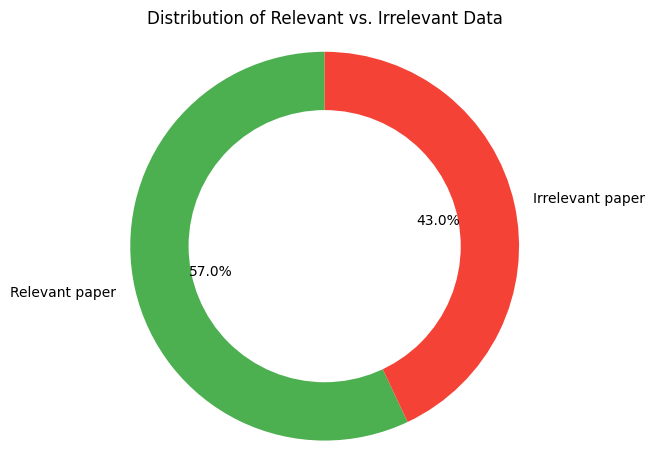

In [14]:
'''
How many papers are relevant vs irrelevant?
'''
relevant_data_size = relevant_data.shape[0]
irrelevant_data_size = irrelevant_data.shape[0]

# Data for the pie chart
sizes = [relevant_data_size, irrelevant_data_size]
labels = ['Relevant paper', 'Irrelevant paper']

# donut pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#F44336'])
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.axis('equal')
plt.title('Distribution of Relevant vs. Irrelevant Data')
plt.tight_layout()

# Show the plot
plt.show()


In [15]:
relevant_data.head(2)

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Abstract,titleAbstractNew,titleAbstractNew_Embedding,titleAbstractNew_Similarity
1,39398866,Characterization of arteriosclerosis based on ...,"Zhou J, Li X, Demeke D, Dinh TA, Yang Y, Janow...",J Med Imaging (Bellingham). 2024 Sep;11(5):057...,Zhou J,J Med Imaging (Bellingham),2024,2024/10/14,PMC11466048,NaN,10.1117/1.JMI.11.5.057501,PURPOSE: Our purpose is to develop a computer ...,characterization arteriosclerosis based comput...,"[[-0.3245347, 0.16597001, 0.2850249, -0.071573...",0.590637
2,39390053,Multi-scale input layers and dense decoder agg...,"Lan X, Jin W.",Sci Rep. 2024 Oct 10;14(1):23729. doi: 10.1038...,Lan X,Sci Rep,2024,2024/10/10,PMC11467340,NaN,10.1038/s41598-024-74701-0,Accurate segmentation of COVID-19 lesions from...,multiscale input layer dense decoder aggregati...,"[[-0.29687816, 0.18080527, 0.28050616, -0.0851...",0.598914


In [23]:
'''
random check into the relevant_data df
'''
row_id = 6406
relevant_data.reset_index(drop=True, inplace=True)
pprint(relevant_data['titleAbstractNew_Similarity'][row_id])
pprint(relevant_data.Abstract[row_id])

0.64085597
('The COVID-19 pandemic and influenza outbreaks have underscored the critical '
 'need for predictive models that can effectively integrate spatial and '
 'temporal dynamics to enable accurate epidemic forecasting. Traditional '
 'time-series analysis approaches have fallen short in capturing the intricate '
 'interplay between these factors. Recent advancements have witnessed the '
 'incorporation of graph neural networks and machine learning techniques to '
 'bridge this gap, enhancing predictive accuracy and providing novel insights '
 'into disease spread mechanisms. Notable endeavors include leveraging human '
 'mobility data, employing transfer learning, and integrating advanced models '
 'such as Transformers and Graph Convolutional Networks (GCNs) to improve '
 'forecasting performance across diverse geographies for both influenza and '
 'COVID-19. However, these models often face challenges related to data '
 'quality, model transferability, and potential overfittin

In [26]:
'''
random check into the irrelevant_data df
'''
row_id = 0
irrelevant_data.reset_index(drop=True, inplace=True)
pprint(irrelevant_data['titleAbstractNew_Similarity'][row_id])
pprint(irrelevant_data.Abstract[row_id])

0.05754281
('Background Incidental extrapulmonary findings are commonly detected on chest '
 'CT scans and can be clinically important. Purpose To integrate artificial '
 'intelligence (AI)-based segmentation for multiple structures, coronary '
 'artery calcium (CAC), and epicardial adipose tissue with automated feature '
 'extraction methods and machine learning to detect extrapulmonary '
 'abnormalities and predict all-cause mortality (ACM) in a large multicenter '
 'cohort. Materials and Methods In this post hoc analysis, baseline chest CT '
 'scans in patients enrolled in the National Lung Screening Trial (NLST) from '
 'August 2002 to September 2007 were included from 33 participating sites. Per '
 'scan, 32 structures were segmented with a multistructure model. For each '
 'structure, 15 clinically interpretable radiomic features were quantified. '
 'Four general codes describing abnormalities reported by NLST radiologists '
 'were applied to identify extrapulmonary significant i

## Classify paper according to the type of method used

Let's classify into:
 - text mining
 - computer vision
 - both
 - others

<ipython-input-18-742c2ddf492f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['method_group'] = relevant_data['titleAbstractNew'].apply(embedding_processor.classify_method)


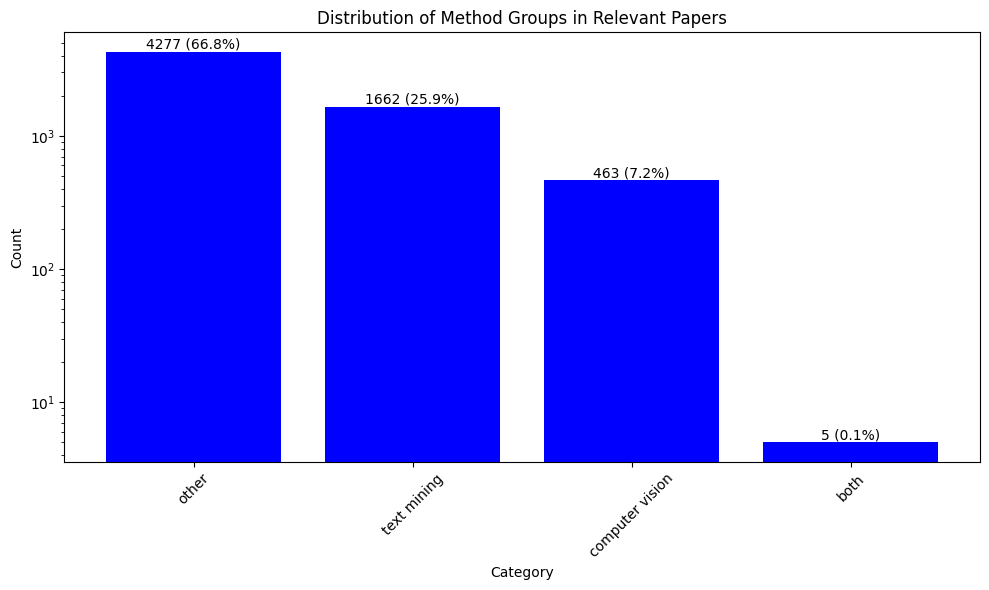

In [18]:
'''
count the method group and plot
'''
relevant_data['method_group'] = relevant_data['titleAbstractNew'].apply(embedding_processor.classify_method)

method_group_counts = relevant_data['method_group'].value_counts()

if 'method_group' in relevant_data.columns:
    plotter.plot_value_counts(method_group_counts, 'Distribution of Method Groups in Relevant Papers')


the majority of relevant papers are classified as "Other" and the combined category of "Both" represent a smaller fraction. This could imply that the research landscape is primarily oriented towards others(such as deep learning), with fewer studies integrating visual data analysis.

Note: the use of a logarithmic scale on the y-axis helps in visualizing the wide range of counts more effectively, especially given that the "Other" category dominates the dataset.

In [19]:
relevant_data.head(2)

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Abstract,titleAbstractNew,titleAbstractNew_Embedding,titleAbstractNew_Similarity,method_group
0,39398866,Characterization of arteriosclerosis based on ...,"Zhou J, Li X, Demeke D, Dinh TA, Yang Y, Janow...",J Med Imaging (Bellingham). 2024 Sep;11(5):057...,Zhou J,J Med Imaging (Bellingham),2024,2024/10/14,PMC11466048,NaN,10.1117/1.JMI.11.5.057501,PURPOSE: Our purpose is to develop a computer ...,characterization arteriosclerosis based comput...,"[[-0.3245347, 0.16597001, 0.2850249, -0.071573...",0.590637,computer vision
1,39390053,Multi-scale input layers and dense decoder agg...,"Lan X, Jin W.",Sci Rep. 2024 Oct 10;14(1):23729. doi: 10.1038...,Lan X,Sci Rep,2024,2024/10/10,PMC11467340,NaN,10.1038/s41598-024-74701-0,Accurate segmentation of COVID-19 lesions from...,multiscale input layer dense decoder aggregati...,"[[-0.29687816, 0.18080527, 0.28050616, -0.0851...",0.598914,other


## Extract and report the name of the method used for each relevant paper.

Let's group the method type into one of these classes:
 - deep learning
 - natural language processing
 - computer vision
 - large language model

<ipython-input-20-fc227a7ea537>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['method_type'] = relevant_data['titleAbstractNew'].apply(embedding_processor.classify_paper)


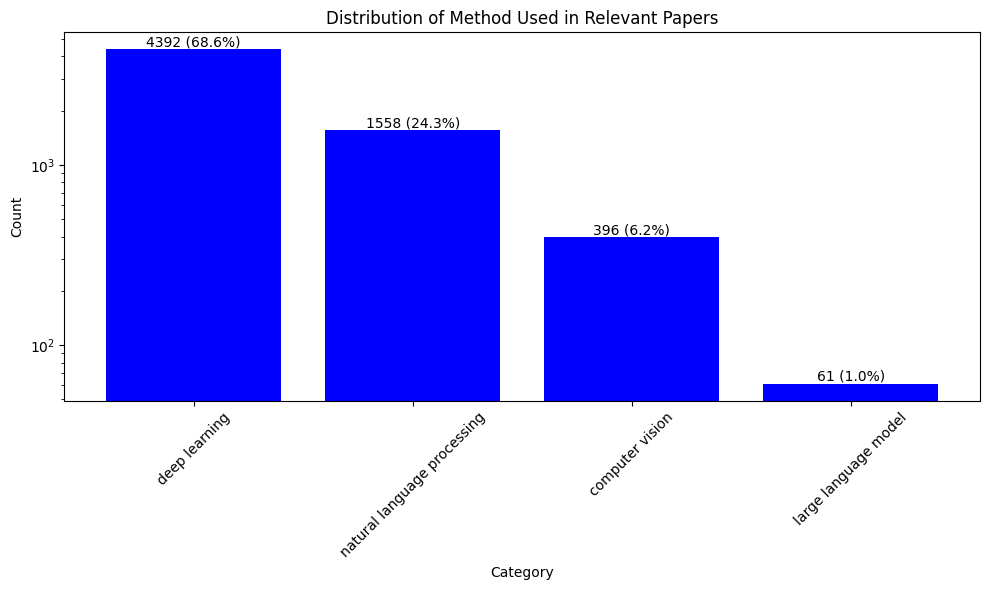

In [20]:
'''
 count the method type and plot
'''
# Classify method type for relevant data
relevant_data['method_type'] = relevant_data['titleAbstractNew'].apply(embedding_processor.classify_paper)

method_type_counts = relevant_data['method_type'].value_counts()

# Plot for method_type
if 'method_type' in relevant_data.columns:
    plotter.plot_value_counts(method_type_counts, 'Distribution of Method Used in Relevant Papers')


this shows a clear preference for deep learning methodologies in the research landscape, followed by natural language processing. The lesser representation of computer vision and large language models suggests either a niche application of these methods or that the current research focus remains primarily on deep learning and NLP techniques.

**Note: for keywords that uses both 'deep learning' and 'computer vision', the algorithm use the first keyword to classify.**

In [21]:
relevant_data.head(2)

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Abstract,titleAbstractNew,titleAbstractNew_Embedding,titleAbstractNew_Similarity,method_group,method_type
0,39398866,Characterization of arteriosclerosis based on ...,"Zhou J, Li X, Demeke D, Dinh TA, Yang Y, Janow...",J Med Imaging (Bellingham). 2024 Sep;11(5):057...,Zhou J,J Med Imaging (Bellingham),2024,2024/10/14,PMC11466048,NaN,10.1117/1.JMI.11.5.057501,PURPOSE: Our purpose is to develop a computer ...,characterization arteriosclerosis based comput...,"[[-0.3245347, 0.16597001, 0.2850249, -0.071573...",0.590637,computer vision,deep learning
1,39390053,Multi-scale input layers and dense decoder agg...,"Lan X, Jin W.",Sci Rep. 2024 Oct 10;14(1):23729. doi: 10.1038...,Lan X,Sci Rep,2024,2024/10/10,PMC11467340,NaN,10.1038/s41598-024-74701-0,Accurate segmentation of COVID-19 lesions from...,multiscale input layer dense decoder aggregati...,"[[-0.29687816, 0.18080527, 0.28050616, -0.0851...",0.598914,other,deep learning
